In [6]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib.lines import Line2D

from Mytorch.utils.augmentation import Augmentation
from Mytorch import nn, optim, tensor, loss
from Mytorch.nn.sequential import Sequential
from Mytorch.nn.linear import Linear
from Mytorch.nn.activation_function import *
from Mytorch.loss.lossFunction import CrossEntropy, MSE
from Mytorch.evaluator.performance import ClassificationPerformance
from Mytorch.optim.sgd import SGD

# import loss
# import optim
# import nn
# from tensor import Tensor

## 定义准确率函数

In [7]:
def accuracy(a, y):
    size = a.shape[0]
    idx_a = np.argmax(a, axis=1)
    idx_y = np.argmax(y, axis=1)
    # cp = ClassificationPerformance(idx_a,idx_y)
    # return cp.getAccuracy()
    acc = sum(idx_a == idx_y)
    return acc

## 加载数据

In [8]:
m = loadmat("dataset/mnist_small_matlab.mat")

trainData, train_labels = m['trainData'], m['trainLabels']
testData, test_labels = m['testData'], m['testLabels']
train_images = trainData.reshape(-1, 10000).transpose(1, 0)
train_labels = train_labels.transpose(1, 0)
test_images = testData.reshape(-1, 2000).transpose(1, 0)
test_labels = test_labels.transpose(1, 0)

train_aug = Augmentation(train_images)
train_aug.work()
train_images = np.concatenate((train_images, train_aug.img))
train_labels = np.concatenate((train_labels, train_labels))

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(40000, 784)
(40000, 10)
(5000, 784)
(5000, 10)


## 定义网络结构

In [9]:
# 初始化各层及激活函数
model = Sequential("sequential")
linear1 = Linear("linear1", 784, 256)
f1 = Relu("f1")
linear2 = Linear("linear2", 256, 100)
f2 = Relu("f2")
linear3 = Linear("linear3", 100, 10)
f3 = SoftMax("f3")

# 构建网络
model.add_module(linear1)
model.add_module(f1)
model.add_module(linear2)
model.add_module(f2)
model.add_module(linear3)
model.add_module(f3)



**********************************
network: odict_keys(['linear1', 'f1', 'linear2', 'f2', 'linear3', 'f3'])
w_dict: odict_keys(['linear1', 'linear2', 'linear3'])
b_dict: odict_keys(['linear1', 'linear2', 'linear3'])
z_dict: odict_keys(['f1', 'f2', 'f3'])
a_dict: odict_keys(['f1', 'f2', 'f3'])
**********************************




findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


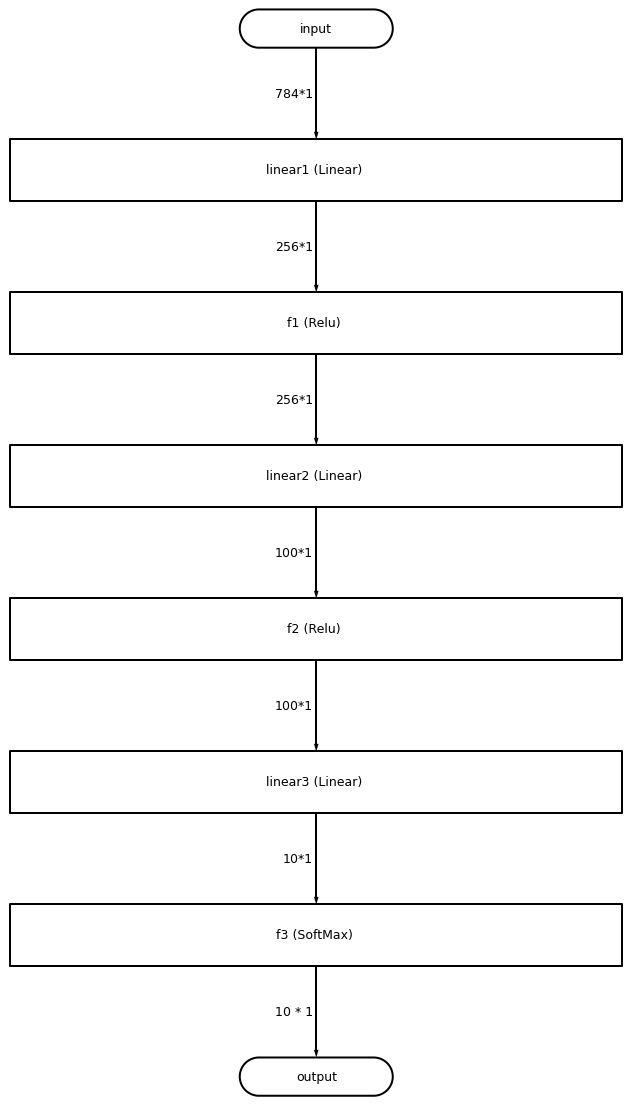

In [10]:
# 可视化网络结构
model.show()

## 训练

In [14]:
optimizer = SGD(model, lr=0.005)
criterion = CrossEntropy()

E_list = []
train_Loss_list = []
train_acc_list = []
test_Loss_list = []
test_acc_list = []
batch_size = 200
max_epoch = 50
for epoch in range(max_epoch):
    E_list.append(epoch)
    
    model.train()
    sample_idxs = np.random.permutation(train_images.shape[0])
    num_batch = int(np.ceil(train_images.shape[0]/batch_size))
    train_cost = 0
    acc = 0
    for batch_idx in range(num_batch):
        x = Tensor(train_images[sample_idxs[batch_size*batch_idx:min(batch_size*(batch_idx + 1),train_images.shape[0])],:])
        y = Tensor(train_labels[sample_idxs[batch_size*batch_idx:min(batch_size*(batch_idx + 1),train_labels.shape[0])],:])
        y_pred = model(x)
        y_pre = y_pred.datas
        acc += accuracy(y, y_pre)
        optimizer.zero_grad()
        loss = criterion(y_pred,y)
        train_cost += loss.datas 

        # print("loss:", loss.datas, "acc:" ,accuracy(y, y_pre))

        loss.backward()
        optimizer.step()
    
    train_cost /= train_images.shape[0]
    acc /= train_images.shape[0]
    train_Loss_list.append(train_cost) 
    train_acc_list.append(acc)


    model.eval()
    sample_idxs = np.random.permutation(test_images.shape[0])
    num_batch = int(np.ceil(test_images.shape[0]/batch_size))
    acc = 0
    test_cost = 0
    for batch_idx in range(num_batch):
            x = Tensor(test_images[sample_idxs[batch_size*batch_idx:min(batch_size*(batch_idx + 1),test_images.shape[0])],:])
            y = Tensor(test_labels[sample_idxs[batch_size*batch_idx:min(batch_size*(batch_idx + 1),test_labels.shape[0])],:])
            y_pre = model(x)
            loss = criterion(y_pre ,y)
            test_cost += loss.datas
            y_pre = y_pre.datas
            acc += accuracy(y, y_pre)
    acc /= test_labels.shape[0]
    test_cost /= test_images.shape[0]
    test_Loss_list.append(test_cost) 
    test_acc_list.append(acc)
    print("epoch= ",epoch," train cost = ",train_Loss_list[-1],"acc on traintset = ",train_acc_list[-1], "\ntest cost = ",test_Loss_list[-1],"acc on testtset = ",test_acc_list[-1])
    # model_name = f'model{epoch + 1000}.pkl'
#     rw = model
#     output_hal = open(model_name, 'wb')
#     str = pickle.dumps(rw)
#     output_hal.write(str)
#     output_hal.close()

epoch=  0  train cost =  0.7792218320928408 acc on traintset =  0.681075 
test cost =  0.6269568049049175 acc on testtset =  0.7336
epoch=  1  train cost =  0.6534754099759892 acc on traintset =  0.74295 
test cost =  0.6070813929076274 acc on testtset =  0.7632
epoch=  2  train cost =  0.5718021778738438 acc on traintset =  0.770425 
test cost =  0.6045724087585922 acc on testtset =  0.754
epoch=  3  train cost =  0.5374918210312604 acc on traintset =  0.78475 
test cost =  0.5535046487999429 acc on testtset =  0.8046
epoch=  4  train cost =  0.5114469953188313 acc on traintset =  0.7982 
test cost =  0.501275065840102 acc on testtset =  0.8178
epoch=  5  train cost =  1.0316427990048882 acc on traintset =  0.680225 
test cost =  0.6260496241591664 acc on testtset =  0.759
epoch=  6  train cost =  0.619014404107643 acc on traintset =  0.750075 
test cost =  0.548489761471527 acc on testtset =  0.7868
epoch=  7  train cost =  0.5637868451141802 acc on traintset =  0.77865 
test cost = 

## 绘制图片

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


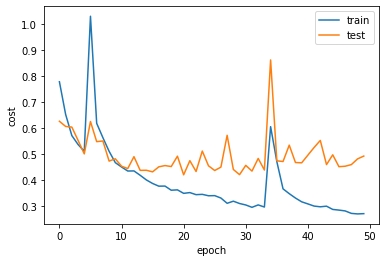

In [15]:
# 绘制cost
plt.xlabel("epoch")
plt.ylabel("cost")
plt.plot(train_Loss_list, label = "train")
plt.plot(test_Loss_list, label = "test")
plt.legend()
plt.savefig("mnist_cost_of_train_and_test.png", dpi = 200)

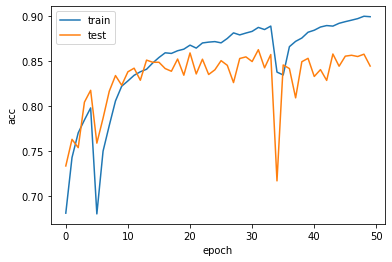

In [16]:
# 绘制acc
plt.xlabel("epoch")
plt.ylabel("acc")
plt.plot(train_acc_list, label = "train")
plt.plot(test_acc_list, label = "test")
plt.legend()
plt.savefig("mnist_acc_of_train_and_test.png", dpi = 200)

## 加载运行好的模型

In [17]:
# model = Net()
# with open("model18.pkl",'rb') as file:
#     model  = pickle.loads(file.read())
batch_size = 200
# 该部分可能会报错，如果之前运行过训练的模块，直接跳过训练模块即可
criterion = CrossEntropy()
model.eval()
num_batch = int(np.ceil(test_images.shape[0]/batch_size))
acc = 0
test_cost = 0
for batch_idx in range(num_batch):
        x = Tensor(test_images[batch_size*batch_idx:min(batch_size*(batch_idx + 1),test_images.shape[0]),:,:,:])
        y = Tensor(test_labels[batch_size*batch_idx:min(batch_size*(batch_idx + 1),test_labels.shape[0]),:])
        y_pre = model(x)
        loss = criterion(y_pre ,y)
        test_cost += loss.datas
        y_pre = y_pre.datas
        acc += accuracy(y, y_pre)
acc /= test_labels.shape[0]
test_cost /= test_images.shape[0]
print(" test cost = ",test_cost,"acc on testtset = ",acc)

IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed